In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import sys

sys.path.append(str(Path("..").resolve()))
from config.settings import DATA_PROCESSED, TRAIN_END, VALID_START, PSI_MONITOR_THRESHOLD, PSI_RETRAIN_THRESHOLD

pd.set_option("display.float_format", "{:,.4f}".format)
print("✅ Imports OK")

✅ Imports OK


In [3]:
fm = pd.read_parquet(DATA_PROCESSED / "risk_scores.parquet")

train = fm[fm["fecha_de_inicio_del_contrato"] <= TRAIN_END].copy()
valid = fm[fm["fecha_de_inicio_del_contrato"] >= VALID_START].copy()

print(f"Training set:   {len(train):,} rows ({train['fecha_de_inicio_del_contrato'].min().date()} → {train['fecha_de_inicio_del_contrato'].max().date()})")
print(f"Validation set: {len(valid):,} rows ({valid['fecha_de_inicio_del_contrato'].min().date()} → {valid['fecha_de_inicio_del_contrato'].max().date()})")
print(f"\nProxy label rate — Train: {train['proxy_strong'].mean()*100:.1f}%  Valid: {valid['proxy_strong'].mean()*100:.1f}%")

Training set:   1,091,339 rows (2019-01-01 → 2021-12-31)
Validation set: 462,255 rows (2022-01-01 → 2022-08-06)

Proxy label rate — Train: 15.8%  Valid: 15.2%


In [4]:
# PSI measures how much a feature distribution has shifted
# between training and validation periods
# PSI < 0.10 = stable
# PSI 0.10-0.20 = monitor
# PSI > 0.20 = retrain required

def compute_psi(train_series, valid_series, n_bins=10):
    """Compute Population Stability Index between two distributions."""
    # Create bins from training data
    breakpoints = np.percentile(train_series.dropna(), 
                                np.linspace(0, 100, n_bins + 1))
    breakpoints = np.unique(breakpoints)
    
    if len(breakpoints) < 3:
        return 0.0
    
    train_counts = np.histogram(train_series.dropna(), bins=breakpoints)[0]
    valid_counts = np.histogram(valid_series.dropna(), bins=breakpoints)[0]
    
    # Avoid division by zero
    train_pct = train_counts / len(train_series)
    valid_pct = valid_counts / len(valid_series)
    
    train_pct = np.where(train_pct == 0, 0.0001, train_pct)
    valid_pct = np.where(valid_pct == 0, 0.0001, valid_pct)
    
    psi = np.sum((valid_pct - train_pct) * np.log(valid_pct / train_pct))
    return psi


# Features to monitor for drift
MONITOR_FEATURES = [
    "log_valor",
    "duracion_dias",
    "dias_firma_a_inicio",
    "is_direct",
    "is_modified",
    "vendor_direct_rate",
    "vendor_modified_rate",
    "agency_hhi",
    "agency_top_vendor_share",
    "splitting_score",
    "network_score",
    "process_anomaly_score",
    "risk_index",
]

psi_results = []
for feature in MONITOR_FEATURES:
    if feature in train.columns and feature in valid.columns:
        psi_val = compute_psi(train[feature], valid[feature])
        status = (
            "✅ Stable" if psi_val < PSI_MONITOR_THRESHOLD
            else "⚠️  Monitor" if psi_val < PSI_RETRAIN_THRESHOLD
            else "🔴 Retrain"
        )
        psi_results.append({
            "feature": feature,
            "psi": psi_val,
            "status": status
        })

psi_df = pd.DataFrame(psi_results).sort_values("psi", ascending=False)

print("Population Stability Index (Train → Validation):\n")
print(f"  {'Feature':<35} {'PSI':>8}  Status")
print("  " + "-" * 58)
for _, row in psi_df.iterrows():
    print(f"  {row['feature']:<35} {row['psi']:>8.4f}  {row['status']}")

Population Stability Index (Train → Validation):

  Feature                                  PSI  Status
  ----------------------------------------------------------
  duracion_dias                         0.4991  🔴 Retrain
  dias_firma_a_inicio                   0.4739  🔴 Retrain
  log_valor                             0.1325  ⚠️  Monitor
  process_anomaly_score                 0.1320  ⚠️  Monitor
  risk_index                            0.1187  ⚠️  Monitor
  network_score                         0.0284  ✅ Stable
  vendor_modified_rate                  0.0262  ✅ Stable
  agency_top_vendor_share               0.0202  ✅ Stable
  vendor_direct_rate                    0.0182  ✅ Stable
  agency_hhi                            0.0169  ✅ Stable
  is_direct                             0.0000  ✅ Stable
  is_modified                           0.0000  ✅ Stable
  splitting_score                       0.0000  ✅ Stable


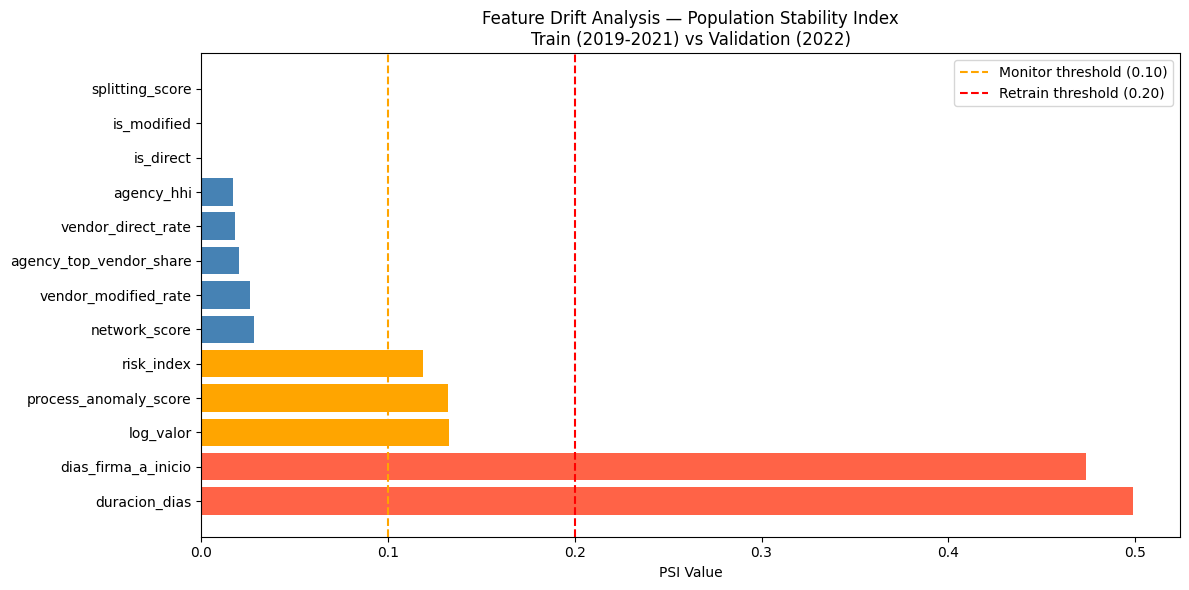

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
colors = [
    "tomato" if p > PSI_RETRAIN_THRESHOLD
    else "orange" if p > PSI_MONITOR_THRESHOLD
    else "steelblue"
    for p in psi_df["psi"]
]
ax.barh(psi_df["feature"], psi_df["psi"], color=colors)
ax.axvline(PSI_MONITOR_THRESHOLD, color="orange", linestyle="--", linewidth=1.5, label="Monitor threshold (0.10)")
ax.axvline(PSI_RETRAIN_THRESHOLD, color="red", linestyle="--", linewidth=1.5, label="Retrain threshold (0.20)")
ax.set_xlabel("PSI Value")
ax.set_title("Feature Drift Analysis — Population Stability Index\nTrain (2019-2021) vs Validation (2022)")
ax.legend()
plt.tight_layout()
plt.savefig("../outputs/charts/08_psi_drift.png", dpi=150)
plt.show()

In [6]:
# Does the model still surface high-risk contracts in validation period?
# Compare precision@K between train and validation

def precision_at_k(scores, labels, k_pct=0.05):
    """What fraction of top-K contracts match the proxy label?"""
    threshold = np.percentile(scores, 100 - k_pct * 100)
    top_k_mask = scores >= threshold
    if top_k_mask.sum() == 0:
        return 0.0
    return labels[top_k_mask].mean()

# Training precision@K
train_p_at_k = precision_at_k(
    train["risk_index"].values,
    train["proxy_strong"].values,
    k_pct=0.05
)

# Validation precision@K
valid_p_at_k = precision_at_k(
    valid["risk_index"].values,
    valid["proxy_strong"].values,
    k_pct=0.05
)

degradation = (train_p_at_k - valid_p_at_k) / train_p_at_k * 100

print("Precision@K (top 5% of risk scores):\n")
print(f"  Training period:    {train_p_at_k:.4f} ({train_p_at_k*100:.1f}%)")
print(f"  Validation period:  {valid_p_at_k:.4f} ({valid_p_at_k*100:.1f}%)")
print(f"  Degradation:        {degradation:.1f}%")
print(f"\n  Interpretation:")
if degradation < 10:
    print(f"  ✅ Model is stable — less than 10% degradation")
elif degradation < 25:
    print(f"  ⚠️  Moderate degradation — monitor monthly")
else:
    print(f"  🔴 Significant degradation — schedule retraining")

Precision@K (top 5% of risk scores):

  Training period:    0.2437 (24.4%)
  Validation period:  0.2011 (20.1%)
  Degradation:        17.5%

  Interpretation:
  ⚠️  Moderate degradation — monitor monthly


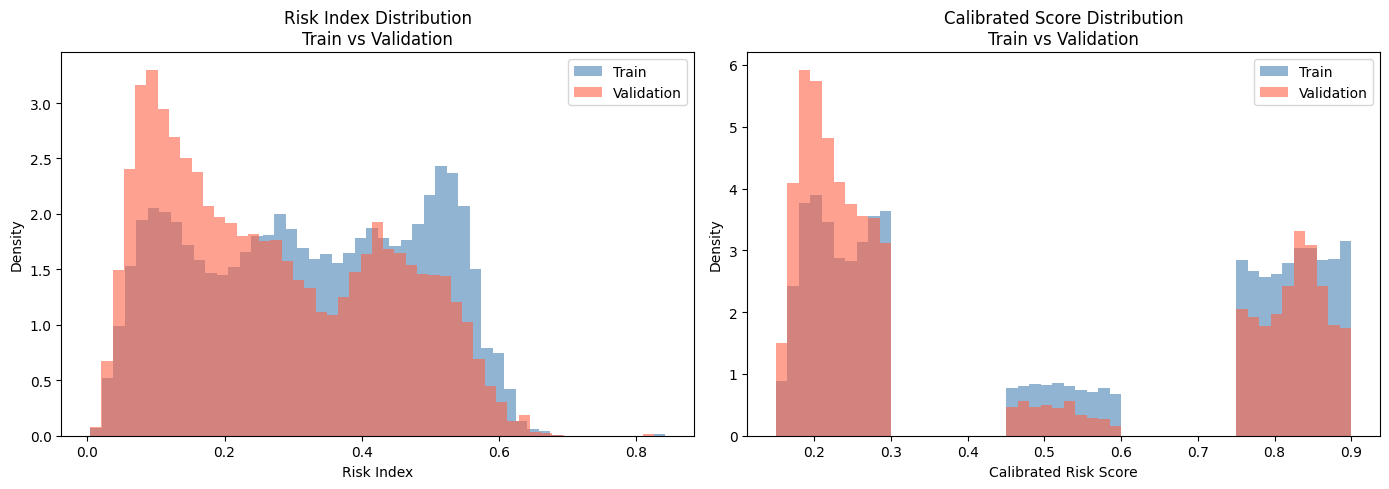

In [7]:
# Visual comparison of risk score distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Risk index distribution
axes[0].hist(train["risk_index"], bins=50, alpha=0.6,
             color="steelblue", label="Train", density=True)
axes[0].hist(valid["risk_index"], bins=50, alpha=0.6,
             color="tomato", label="Validation", density=True)
axes[0].set_title("Risk Index Distribution\nTrain vs Validation")
axes[0].set_xlabel("Risk Index")
axes[0].set_ylabel("Density")
axes[0].legend()

# Calibrated score distribution
axes[1].hist(train["risk_score_calibrated"], bins=50, alpha=0.6,
             color="steelblue", label="Train", density=True)
axes[1].hist(valid["risk_score_calibrated"], bins=50, alpha=0.6,
             color="tomato", label="Validation", density=True)
axes[1].set_title("Calibrated Score Distribution\nTrain vs Validation")
axes[1].set_xlabel("Calibrated Risk Score")
axes[1].set_ylabel("Density")
axes[1].legend()

plt.tight_layout()
plt.savefig("../outputs/charts/08_score_distribution_shift.png", dpi=150)
plt.show()

In [8]:
# Contracts scored high-risk in training period —
# were they more likely to be modified in the validation period?
# This is forward-looking validation without ground truth labels.

# Flag high-risk contracts from training period
train_high = train[train["risk_tier"] == "High"]["codigo_entidad"].unique()

# In validation, do agencies that were high-risk show higher modification rates?
valid["agency_was_high_risk"] = valid["codigo_entidad"].isin(train_high).astype(int)

mod_rate_high = valid[valid["agency_was_high_risk"] == 1]["is_modified"].mean()
mod_rate_low  = valid[valid["agency_was_high_risk"] == 0]["is_modified"].mean()

ratio = mod_rate_high / mod_rate_low if mod_rate_low > 0 else 0

print("Predictive Validation:")
print(f"  Agencies flagged High-risk in training:  {len(train_high):,}")
print(f"\n  In validation period:")
print(f"  Modification rate — previously High-risk agencies: {mod_rate_high*100:.1f}%")
print(f"  Modification rate — other agencies:                {mod_rate_low*100:.1f}%")
print(f"  Ratio:                                             {ratio:.2f}x")
print(f"\n  Interpretation:")
if ratio > 1.2:
    print(f"  ✅ High-risk agencies show {ratio:.1f}x higher modification rate")
    print(f"     — scores have real predictive signal")
else:
    print(f"  ⚠️  Limited predictive separation — document in methodology")

Predictive Validation:
  Agencies flagged High-risk in training:  1,805

  In validation period:
  Modification rate — previously High-risk agencies: 17.0%
  Modification rate — other agencies:                11.5%
  Ratio:                                             1.48x

  Interpretation:
  ✅ High-risk agencies show 1.5x higher modification rate
     — scores have real predictive signal


In [9]:
print("=" * 60)
print("RECOMMENDED MONITORING PROTOCOL")
print("=" * 60)
print("""
Monthly checks:
  1. Recompute PSI for all 13 monitored features
  2. Flag any feature with PSI > 0.10 for investigation
  3. Recompute Precision@K on most recent 90-day window

Retraining triggers:
  - Any feature PSI > 0.20
  - Precision@K drops more than 25% from baseline
  - API schema change detected in ingestion layer

Schema drift handling:
  - Run ingest.py with --test flag monthly
  - Compare column list against expected schema
  - Alert if new columns appear or existing columns go null

Retraining cadence (recommended):
  - Scheduled: annually (new fiscal year)
  - Triggered: when any PSI threshold breached
""")

drifted = psi_df[psi_df["psi"] > PSI_MONITOR_THRESHOLD]
print(f"Features currently requiring monitoring: {len(drifted)}")
if len(drifted) > 0:
    print(drifted[["feature", "psi", "status"]].to_string(index=False))

RECOMMENDED MONITORING PROTOCOL

Monthly checks:
  1. Recompute PSI for all 13 monitored features
  2. Flag any feature with PSI > 0.10 for investigation
  3. Recompute Precision@K on most recent 90-day window

Retraining triggers:
  - Any feature PSI > 0.20
  - Precision@K drops more than 25% from baseline
  - API schema change detected in ingestion layer

Schema drift handling:
  - Run ingest.py with --test flag monthly
  - Compare column list against expected schema
  - Alert if new columns appear or existing columns go null

Retraining cadence (recommended):
  - Scheduled: annually (new fiscal year)
  - Triggered: when any PSI threshold breached

Features currently requiring monitoring: 5
              feature    psi      status
        duracion_dias 0.4991   🔴 Retrain
  dias_firma_a_inicio 0.4739   🔴 Retrain
            log_valor 0.1325 ⚠️  Monitor
process_anomaly_score 0.1320 ⚠️  Monitor
           risk_index 0.1187 ⚠️  Monitor


In [10]:
# Save PSI results
psi_df.to_csv("../outputs/tables/psi_drift_report.csv", index=False)

print("=" * 55)
print("✅ TEMPORAL VALIDATION COMPLETE")
print("=" * 55)
print(f"  Training rows:        {len(train):,}")
print(f"  Validation rows:      {len(valid):,}")
print(f"  Precision@K train:    {train_p_at_k*100:.1f}%")
print(f"  Precision@K valid:    {valid_p_at_k*100:.1f}%")
print(f"  Degradation:          {degradation:.1f}%")
print(f"  Features monitored:   {len(psi_df)}")
print(f"  Features drifted:     {len(psi_df[psi_df['psi'] > PSI_MONITOR_THRESHOLD])}")
print(f"  Predictive ratio:     {ratio:.2f}x")
print(f"  PSI report saved:     outputs/tables/psi_drift_report.csv")
print("=" * 55)

✅ TEMPORAL VALIDATION COMPLETE
  Training rows:        1,091,339
  Validation rows:      462,255
  Precision@K train:    24.4%
  Precision@K valid:    20.1%
  Degradation:          17.5%
  Features monitored:   13
  Features drifted:     5
  Predictive ratio:     1.48x
  PSI report saved:     outputs/tables/psi_drift_report.csv


In [11]:
print("Precision@K at multiple thresholds:")
for k in [0.01, 0.05, 0.10]:
    p = precision_at_k(train["risk_index"].values, train["proxy_strong"].values, k_pct=k)
    print(f"  Top {k*100:.0f}%: {p*100:.1f}%")

print(f"\nRandom baseline (proxy rate): {train['proxy_strong'].mean()*100:.1f}%")

Precision@K at multiple thresholds:
  Top 1%: 18.0%
  Top 5%: 24.4%
  Top 10%: 20.6%

Random baseline (proxy rate): 15.8%
